In [1]:
import PIL
from scipy.io import savemat, loadmat
import numpy as np
import os
import h5py
from svhn_utils import file2tensor, parse_digit_struct

<ol>
<li><a href="#Cropping-Resizing-and-Arrayifying-Photos">Cropping Resizing and Arrayifying Photos</a></li>
<li><a href="#Parsing-digitStruct-and-Getting-Labels">Parsing digitStruct and Getting Labels</a></li>
<li><a href="#Saving-to-File">Saving to File</a></li>
</ol>

# Cropping Resizing and Arrayifying Photos

In [5]:
!dir "./SVHN_Data/images"

 Volume in drive C has no label.
 Volume Serial Number is 7816-5F49

 Directory of C:\Users\Ian\Documents\Programming\SVHN_DeepLearning\SVHN_Data\images

06/05/2017  01:28 AM    <DIR>          .
06/05/2017  01:28 AM    <DIR>          ..
06/05/2017  01:27 AM    <DIR>          test
06/05/2017  01:27 AM    <DIR>          train
               0 File(s)              0 bytes
               4 Dir(s)  1,580,328,579,072 bytes free


In [12]:
train_files = [os.path.join('./SVHN_Data/images/train/', x) for x in os.listdir('./SVHN_Data/images/train/') if x[-3:]=='png']
test_files = [os.path.join('./SVHN_Data/images/test/', x) for x in os.listdir('./SVHN_Data/images/test/') if x[-3:] == 'png']
train_files[0]

'./SVHN_Data/images/train/1.png'

Since most of the photos have a ratio of ~0.5, and I don't want to distort the photos, I will pad the images to have a ratio of 0.5 and resize to 64x32

In [7]:
%%time 
sizes = []
ratios = []
for f in train_files:
    size = PIL.Image.open(f).size    
    sizes.append(size)
    ratios.append(size[1] / size[0])
print(np.mean(ratios))
print(np.max(ratios))
print(1/np.min(ratios))

0.449952175112
1.09677419355
5.53488372093
Wall time: 4.34 s


In [8]:
sizes = np.array(sizes)
print(sizes[:, 0].min())
print(sizes[:, 0].max())
print(sizes[:, 1].min())
print(sizes[:, 1].max())

25
876
12
501


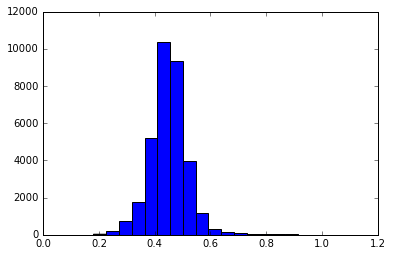

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ratios, bins=20)
plt.show()

In [13]:
%%time
train_data = np.array([file2tensor(f) for f in train_files])
test_data = np.array([file2tensor(f) for f in test_files])
print(train_data.shape)

(33402, 32, 64, 3)
Wall time: 39.9 s


This one happens to be useless regardless of the ratio/cropping, and even so it's not bad

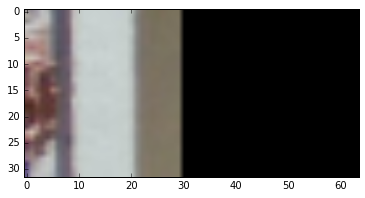

In [14]:
plt.imshow(train_data[np.argmax(ratios)])

On the other end of the spectrum, this one is pretty bad...830? Hard to read even for a human.

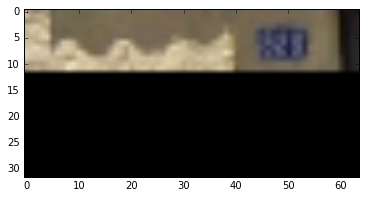

In [15]:
plt.imshow(train_data[np.argmin(ratios)])

# Parsing digitStruct and Getting Labels

In [16]:
train_digit_struct = h5py.File('./SVHN_Data/images/train/digitStruct.mat', mode='r')
test_digit_struct = h5py.File('./SVHN_Data/images/test/digitStruct.mat', mode='r')

In [17]:
%%time
train_bbox_dicts = parse_digit_struct(train_digit_struct)
test_bbox_dicts = parse_digit_struct(test_digit_struct)

Wall time: 2min 56s


In [18]:
train_labels = []
for filename in train_files:
    basename = os.path.basename(filename)
    try:
        train_labels.append([int(box['label']) for box in train_bbox_dicts[basename]])
    except Exception as e:
        print(basename)
        raise e
train_labels[0]

[1, 9]

In [19]:
test_labels = []
for filename in test_files:
    basename = os.path.basename(filename)
    try:
        test_labels.append([int(box['label']) for box in train_bbox_dicts[basename]])
    except Exception as e:
        print(basename)
        raise e

In [22]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
def shuffle(x, *args, seed=None):
    idx = np.arange(len(x))
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(idx)    
    x = x[idx]
    targs = [arg[idx] for arg in args]
    if len(targs) > 0:
        return [x] + targs
    else:
        return x
train_data, train_labels = shuffle(train_data, train_labels, seed=147258)
test_data, test_labels = shuffle(test_data, test_labels, seed=147258)

# Saving to File

In [23]:
if not os.path.exists('./SVHN_Data/tensors/'):
    os.mkdir('./SVHN_Data/tensors/')
savemat('./SVHN_Data/tensors/train.mat', {'data': train_data, 
                                          'labels': train_labels})
savemat('./SVHN_Data/tensors/test.mat', {'data': test_data, 
                                          'labels': test_labels})